## Imports and setup

In [ ]:
%%capture
!pip install -q wandb

In [ ]:
# Authorize wandb
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
# Which GPU?
!nvidia-smi

Sun Oct  4 05:24:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py

--2020-10-04 05:24:11--  https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6064 (5.9K) [text/plain]
Saving to: ‘resnet_cifar10.py’

resnet_cifar10.py   100%[===================>]   5.92K  --.-KB/s    in 0s      

2020-10-04 05:24:11 (66.4 MB/s) - ‘resnet_cifar10.py’ saved [6064/6064]



In [ ]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import tensorflow as tf
import resnet_cifar10
import numpy as np
import time

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

from wandb.keras import WandbCallback

## Utilities

In [ ]:
def get_training_model():
  # ResNet20
  n = 2
  depth =  n * 9 + 2
  n_blocks = ((depth - 2) // 9) - 1

  # The input tensor
  inputs = Input(shape=(32, 32, 3))

  # The Stem Convolution Group
  x = resnet_cifar10.stem(inputs)

  # The learner
  x = resnet_cifar10.learner(x, n_blocks)

  # The Classifier for 10 classes
  outputs = resnet_cifar10.classifier(x, 10)

  # Instantiate the Model
  model = Model(inputs, outputs)

  return model

In [ ]:
def plot_training(H):
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()

## Dataset preparation

In [ ]:
# Load the training set of CIFAR10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Scale the pixel values
x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
model = get_training_model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_166 (Conv2D)             (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 32, 32, 16)   64          conv2d_166[0][0]                 
__________________________________________________________________________________________________
re_lu_164 (ReLU)                (None, 32, 32, 16)   0           batch_normalization_164[0][0]    
_______________________________________________________________________________________

## Training

In [ ]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


Epoch 1/75
782/782 [==============================] - 17s 22ms/step - loss: 1.3264 - accuracy: 0.5187 - val_loss: 1.2806 - val_accuracy: 0.5405
Epoch 2/75
782/782 [==============================] - 17s 22ms/step - loss: 0.9245 - accuracy: 0.6699 - val_loss: 1.2270 - val_accuracy: 0.5914
Epoch 3/75
782/782 [==============================] - 17s 22ms/step - loss: 0.7554 - accuracy: 0.7325 - val_loss: 1.0196 - val_accuracy: 0.6586
Epoch 4/75
782/782 [==============================] - 17s 22ms/step - loss: 0.6322 - accuracy: 0.7780 - val_loss: 1.0105 - val_accuracy: 0.6712
Epoch 5/75
782/782 [==============================] - 17s 22ms/step - loss: 0.5320 - accuracy: 0.8138 - val_loss: 0.9935 - val_accuracy: 0.6868
Epoch 6/75
782/782 [==============================] - 17s 22ms/step - loss: 0.4465 - accuracy: 0.8435 - val_loss: 0.8874 - val_accuracy: 0.7166
Epoch 7/75
782/782 [==============================] - 17s 22ms/step - loss: 0.3749 - accuracy: 0.8686 - val_loss: 0.7486 - val_accuracy:

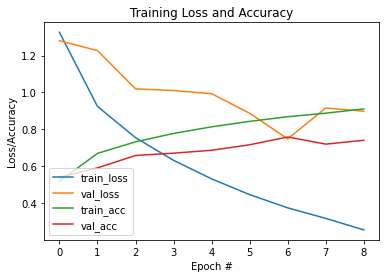

In [ ]:
# Train model
model = get_training_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
wandb.init(entity="g-simclr", project="g-simclr", id="cifar10_supervised_training")
h = model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         batch_size=64,
         epochs=75,
         callbacks=[es, WandbCallback()])

plot_training(h)